## Import Modules

This imports key modules for running a pytorch image classifier

In [0]:
# Declare computer type that we are using upfront enables easy conversion between programs
comptype = 'googlecolab'

In [0]:
def imports_googlecolab():
    from google.colab import drive
    # mount the drive
    drive.mount('/content/gdrive/')
    
    # get the flower data
    !wget -cq https://s3.amazonaws.com/content.udacity-data.com/courses/nd188/flower_data.zip
    !unzip -qq flower_data.zip
    
    # download and install pytorch packages
    from os.path import exists
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
    cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
    accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'
    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
    !pip install Pillow==5.3.0

In [3]:
# set directory path for easy conversion between programs

if comptype == 'googlecolab':
    DIRPATH = '/content/gdrive/My Drive/PytorchChallenge/'
    imports_googlecolab()
else:
    DIRPATH = 'C:/Work/Programming/Python/Udacity/PytorchChallenge/pytorch_challenge/'

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
replace flower_data/valid/61/image_06296.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [4]:
# Import key modules
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from PIL import Image
import PIL
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torch
from collections import OrderedDict, Counter
import numpy as np
import time
from tqdm import tqdm_notebook as tqdm
from torch.optim import lr_scheduler
import json
import os
from sklearn.metrics import confusion_matrix
print(PIL.PILLOW_VERSION)

5.3.0


## Prepare Data for Models

Options include re-weighting data to account for imbalances in dataset that may cause model to underperform.  It transforms images into standard form and does some rotations and flipping on image data to help model to generalize.

In [0]:
# Define transforms for the training and validation sets

def make_weights_for_balanced_classes(images, nclasses):
    """Create weights to ensure even distribution and improve learning."""
    
    count = [0] * nclasses                                                      
    for item in images:                                                         
        count[item[1]] += 1                                                     
    weight_per_class = [0.] * nclasses                                      
    N = float(sum(count))                                                   
    for i in range(nclasses):                                                   
        weight_per_class[i] = N/float(count[i])                                 
    weight = [0] * len(images)                                              
    for idx, val in enumerate(images):                                          
        weight[idx] = weight_per_class[val[1]]                                  
    return weight  


def prepare_data(use_weights=False, debug=False):
    """Prepare data by:
    1.  Creating transforms
    2.  Dataloaders
    3.  Get datasize counts
    4.  Converting tag2id
    """
    
    data_dir = './flower_data'
    
    itransforms = {}
    itransforms['train'] = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

    itransforms['valid'] = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    
    itransforms['test'] = itransforms['valid']
    
    idata = {}
    dl = {}
    counts = {}
    for key in ['train','valid']:
        # TODO: Load the datasets with ImageFolder
        idata[key] = datasets.ImageFolder(data_dir + '/' + key, transform=itransforms[key])
        # Given imbalance in class structure.  This could significant prevent network from learning....
        shuffle = None
        sampler = None
        weights = None
        if key == 'train':
            if use_weights:
                # TODO check to see if can get this to work
                # For unbalanced dataset we create a weighted sampler                       
                weights = make_weights_for_balanced_classes(idata[key], len(idata[key].classes))                                                         
                weights = torch.DoubleTensor(weights)                                       
                sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, len(weights))                     
            else:
                shuffle = True
                
        # Using the image datasets and the trainforms, define the dataloaders
        dl[key] = torch.utils.data.DataLoader(idata[key], batch_size=32, shuffle=shuffle, sampler=sampler)
        # Examine the balance of the data 
        counts[key] = Counter([label for image, label in idata[key]])
            
    datasize = {key: len(idata[key])  for key, value in idata.items()}
    print(datasize)
    print(counts)
    
    # make sure the labeling for the various image folders are the same
    shared_items = {k: idata['valid'].class_to_idx[k] for k in idata['train'].class_to_idx if k in idata['valid'].class_to_idx and idata['train'].class_to_idx[k] == idata['valid'].class_to_idx[k]}
    assert len(shared_items) == len(idata['valid'].class_to_idx.keys()), "Error:  Mappings between train and validation are not the same."
    
    # get id2tag information
    with open(DIRPATH + 'cat_to_name.json', 'r') as f:
        cat_to_name = json.load(f)

    # map the names from encoded id (via ImageFolder) to the flower name
    id2tag = {idata['train'].class_to_idx[cat]:name for cat, name in cat_to_name.items()}
    print(id2tag)
    print(len(id2tag))
    
    return(itransforms, idata, dl, datasize, id2tag, cat_to_name, weights)

In [6]:
itransforms, idata, dl, datasize, id2tag, cat_to_name, weights = prepare_data(debug=True)
print(datasize)

{'train': 6552, 'valid': 818}
{'train': Counter({49: 206, 77: 205, 43: 157, 90: 153, 73: 147, 74: 142, 82: 135, 96: 132, 89: 116, 78: 112, 84: 104, 97: 101, 40: 100, 38: 97, 75: 95, 33: 92, 54: 92, 64: 88, 56: 86, 59: 85, 76: 83, 81: 82, 83: 82, 72: 77, 6: 73, 41: 73, 48: 73, 18: 72, 98: 72, 51: 70, 80: 70, 5: 68, 100: 68, 50: 67, 85: 66, 92: 66, 12: 65, 71: 64, 24: 62, 32: 62, 26: 61, 44: 61, 11: 60, 93: 59, 45: 57, 53: 56, 57: 56, 23: 55, 37: 54, 47: 54, 99: 54, 94: 53, 65: 51, 70: 51, 88: 51, 55: 50, 101: 50, 3: 49, 14: 49, 39: 49, 27: 48, 61: 48, 86: 48, 87: 48, 17: 47, 52: 47, 15: 46, 68: 46, 8: 44, 34: 44, 36: 44, 67: 43, 62: 42, 63: 42, 91: 41, 1: 38, 7: 38, 9: 38, 13: 38, 46: 38, 4: 36, 10: 36, 22: 36, 25: 36, 28: 36, 60: 36, 66: 36, 2: 35, 19: 35, 58: 35, 16: 34, 20: 34, 79: 34, 95: 34, 21: 33, 31: 33, 35: 33, 42: 33, 69: 33, 29: 31, 30: 28, 0: 27}), 'valid': Counter({49: 28, 89: 25, 77: 21, 76: 20, 73: 19, 43: 18, 82: 18, 11: 16, 38: 16, 90: 16, 74: 15, 40: 14, 56: 14, 59: 14

## Visualize tranformed images

Visualize transformed images and tags.

In [0]:
# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow((np.transpose(img, (1, 2, 0))* 255).astype(np.uint8))  # convert from Tensor image

    #(out * 255).astype(np.uint8)
def visualize_images(data_dl):
    # obtain one batch of training images
    dataiter = iter(data_dl)
    images, labels = dataiter.next()
    images = images.numpy() # convert images to numpy for display
    #print(labels)
    # plot the images in the batch, along with the corresponding labels
    fig = plt.figure(figsize=(25, 4))
    # display 20 images
    for idx in np.arange(20):
        ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
        
        imshow(images[idx])
        ax.set_title(id2tag[int(labels[idx].numpy())])

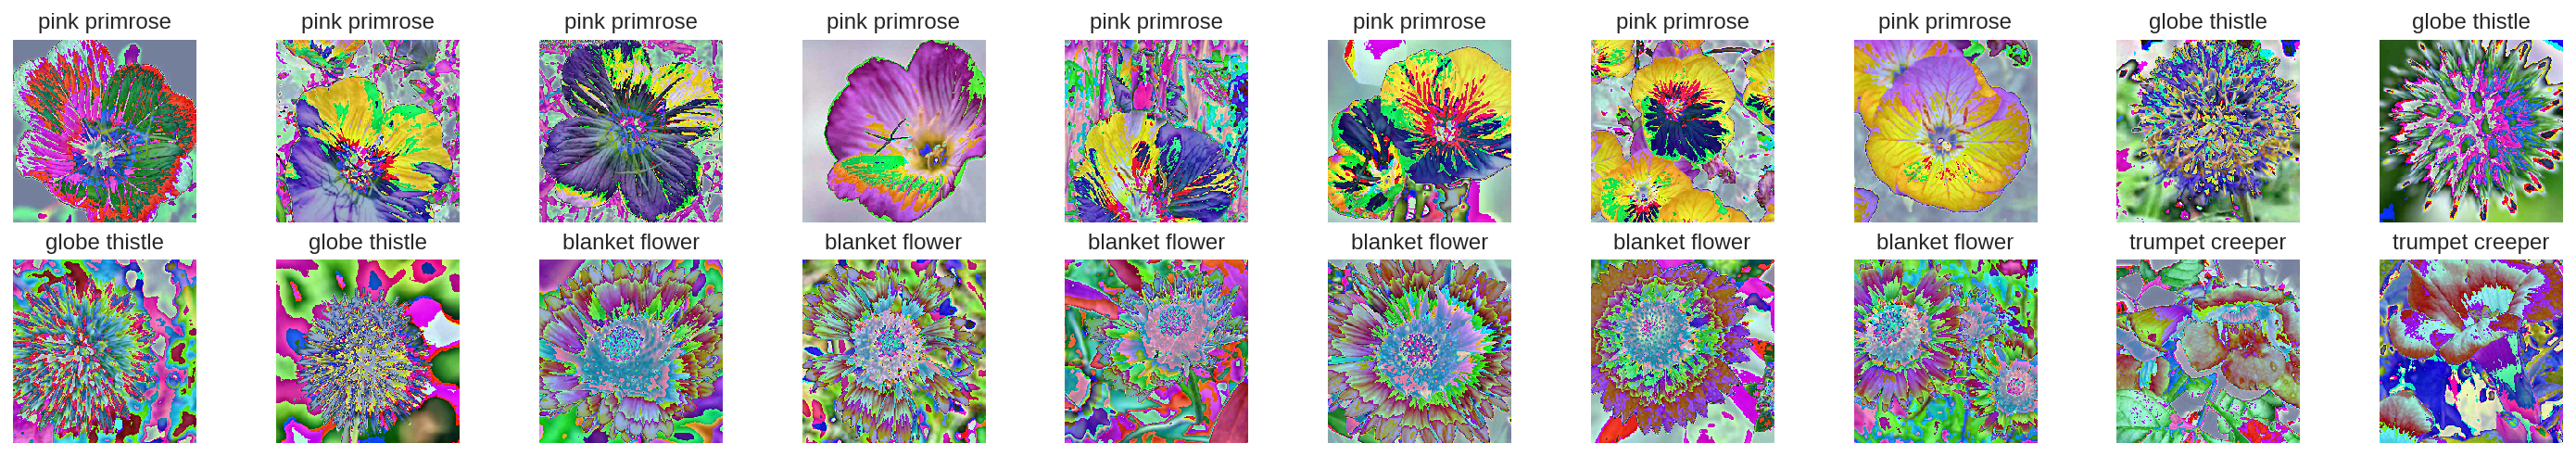

In [8]:
visualize_images(dl['valid'])

# Generate model

Develop general function to
1.  Employ transfer learning from key pre-trained image networks which freezes gradients
2.  Build a classifier for training based on various parameters of hidden layer size, dropout percentage and number of classification divisions

In [0]:
# Employ transfer learning using pre-trained network
# Choose Densenet since one of the more recent pre-trained networks that are easily available and use densenet161 
# this has lowest error

# choose different models

def generate_models(basemodel):
    
    if basemodel == 'densenet':
        model = models.densenet161(pretrained=True)
        in_features = 2208
    elif basemodel == 'vgg':
        model = models.vgg19(pretrained=True)
        in_features = 25088
    else:
        ValueError("Pick valid modeltype")
    
    # Turn off gradients for base model
    # Freeze parameters from pre-trained networks so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    
    return model, in_features


In [0]:
# Build model classifier for training

def build_model(basemodel, out_features, hidden_layers, dropout):
    """Generalized function for building the model"""
    
    # get the base model
    model, in_features = generate_models(basemodel)

    classifier = nn.Sequential()

    if hidden_layers == None:
        classifier.add_module('fc0', nn.Linear(in_features, out_features))
    else:
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        classifier.add_module('fc0', nn.Linear(in_features, hidden_layers[0]))
        classifier.add_module('relu0', nn.ReLU())
        classifier.add_module('drop0', nn.Dropout(dropout))
        for i, (h1, h2) in enumerate(layer_sizes):
            print(h1, h2)
            classifier.add_module('fc'+str(i+1), nn.Linear(h1, h2))
            classifier.add_module('relu'+str(i+1), nn.ReLU())
            classifier.add_module('drop'+str(i+1), nn.Dropout(dropout))
        classifier.add_module('out', nn.Linear(hidden_layers[-1], out_features))
        
    classifier.add_module('output', nn.LogSoftmax(dim=1))
        
    model.classifier = classifier
        
    return model
    
    




## Training class

This is a generalized class for training, evaluation, and tracking of key metrics over time.  It is generalized to accept different models, optimizers, loss functions, and learning rate schedulers.  

In [0]:
# Train Network

class PytorchTrain(object):
    
    def __init__(self, model, train_dl, test_dl, lossfn, optim, learning_rate, id2tag, datasize, modelname, scheduler=None, debug=False):
        
        self.model = model
        self.modelname = modelname
        self.scheduler = scheduler
        
        # initialize optimizer and loss function
        self.learning_rate = learning_rate
        self.optim = optim
        self.lossfn = lossfn

        # store the data
        self.train_dl = train_dl
        self.test_dl = test_dl
        self.datasize = datasize
        
        # metrics to store by epoch
        self.metrics = {}
        metrics = ['loss','accuracy']
        for t in ['train','test']:
            self.metrics[t] = {}
            for v in metrics:
                self.metrics[t][v] = []
                
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        # set behavior for reproducibility
        random_seed = 999
        torch.cuda.manual_seed_all(random_seed) if torch.cuda.is_available() else torch.manual_seed(random_seed)
        torch.backends.cudnn.deterministic=True
        np.random.seed(random_seed)
        
        self.save_model_check = DIRPATH + '/models/m%s_flowers_check.pt' % (modelname) 
        self.save_model_best = DIRPATH + '/models/m%s_flowers_best.pt' % (modelname)
        self.save_every = 1
        self.figdir = './figures'
        self.id2tag = id2tag
        self.debug = debug
        
    def _final_metrics(self, mode, loss, accuracy, end_epoch=False):
        """Compute and store metrics for the epoch."""

        if end_epoch:
            self.metrics[mode]['loss'].append(loss)
            self.metrics[mode]['accuracy'].append(accuracy)
        return accuracy 
        
    def visualize_results(self):
        # obtain one batch of test images
        dataiter = iter(test_loader)
        images, labels = dataiter.next()
        images.numpy()

        # move model inputs to cuda, if GPU available
        if train_on_gpu:
            images = images.cuda()

        # get sample outputs
        output = model(images)
        # convert output probabilities to predicted class
        _, preds_tensor = torch.max(output, 1)
        preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

        # plot the images in the batch, along with predicted and true labels
        fig = plt.figure(figsize=(25, 4))
        for idx in np.arange(20):
            ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
            imshow(images[idx])
            ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
        
        
    def visualize_confusion_matrix(self, ytrue, ypred, class_names, title='confusion matrix', normalize=True):
        
        cm = confusion_matrix(y_true, y_pred, labels=None, sample_weight=None)
        classes=class_names
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
            print("Normalized confusion matrix")
        else:
            print('Confusion matrix, without normalization')

        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.gcf().clear()
        
        
    def process_image(self, image_path):
        """Load and transform image using same process."""
        
        image = Image.open(image_path).convert('RGB')
    
        # large images will slow down processing
        if max(image.size) > max_size:
            size = max_size
        else:
            size = max(image.size)
    
        if shape is not None:
            size = shape
        
        val_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    
        
        # discard the transparent, alpha channel (that's the :3) and add the batch dimension
        image = val_transform(image).unsqueeze(0)

        return image
    

    def predict(self, image_path, topk=5):
        """Make a prediction.  Assumes that the last output is a liner layer
        in last module of the classifier.  (i.e. no softmax)
        """
                
        image = process_image(image_path)
        # make sure we are just cpu bound
        self.model.to('cpu')
        self.model.eval()
        with torch.no_grad():
            outputs = model.forward(image)
            prob = F.softmax(outputs,dim=1)
            top_probs, top_classes = prob.cpu().topk(topk, dim=1)            
            
        return(top_probs, top_classes)

        
    def _train(self):
        """Train the model in batches for given epoch for 
        hierarchical attention model
        ."""
        
        totloss, totcorr = 0.0, 0.0
        self.model.to(self.device)
        self.model.train()

        i = 0
        
        for inputs, labels in tqdm(self.train_dl):
            
            # Step 0:  Take the data to the proper device
            inputs, labels = inputs.to(self.device), labels.to(self.device)        

            # Step 1:  clear out gradients
            self.optim.zero_grad()
            
            # Step 2:  Forward pass
            outputs = model.forward(inputs)
            
            # Step 3:  Evaluate loss
            loss = self.lossfn(outputs, labels)
            
            # Step 4:  Take step of learning rate
            if self.scheduler is not None:
                self.scheduler.step()
            
            # Step 5:  Backpropogate losses
            loss.backward()
            
            # Step 5:  Take a step with the optimizer to minimize loss
            self.optim.step()
            
            prob = torch.exp(outputs)
            totloss += loss.item()
            
            _, pred = torch.max(outputs.data, 1)
            totcorr += (pred == labels).sum().item()
            totloss += loss.item()*labels.size(0)
            
            if self.debug and i > 2:
                break
            i += 1
            
        # take the average of total
        losses = totloss/self.datasize['train']
        accuracy = totcorr/self.datasize['train']

        self._final_metrics('train', losses, accuracy, end_epoch=True)
        print("Train: loss %0.3f; accuracy: %0.3f" % (losses, accuracy))

    def _test(self):
        """Test the model for a given batch."""
 
        # put model into evaluation mode
        self.model.to(self.device)
        self.model.eval()
        totloss, totcorr = 0.0, 0.0
        #ytrue = []
        with torch.no_grad():
            i = 0
            for inputs, labels in tqdm(self.test_dl):

                inputs, labels = inputs.to(self.device), labels.to(self.device)        

                outputs = model.forward(inputs)
            
                loss = self.lossfn(outputs, labels)
                
                _, pred = torch.max(outputs.data, 1)
                totcorr += (pred == labels).sum().item()
                totloss += loss.item()*labels.size(0)
                
                if self.debug and i > 2:
                    break
                i += 1
            
        # take the average of total
        losses = totloss/self.datasize['valid']
        accuracy = totcorr/self.datasize['valid']

        self._final_metrics('test', losses, accuracy, end_epoch=True)
        print("Test: loss %0.3f; accuracy: %0.3f" % (losses, accuracy))
        
        # plot confusion matrix
        #if len(self.metrics['test']['loss']) % 5 == 0:
        #    plot_confusion_matrix(ytrue, ypred, self.id2tag, self.figdir, self.opts.modelname, normalize=True,
        #              title='Normalized confusion matrix\%s' % (self.opts.modelname))
        
    def _save_model(self, filename):
        """Save the model."""
        print("Saving model")
        modelinfo = {}
        #modelinfo['opts'] = self.opts
        modelinfo['id2tag'] = self.id2tag
        modelinfo['epoch'] = len(self.metrics['test']['loss'])
        modelinfo['metrics'] = self.metrics
        modelinfo['model'] = self.model
        modelinfo['optim'] = self.optim
        #modelinfo['params'] = self.params
        modelinfo['state_dict'] = self.model.state_dict()
        torch.save(modelinfo, filename)
        
    def load_checkpoint(self, filepath):
        
        modelinfo = torch.load(filepath, map_location=self.device)
        self.id2tag = modelinfo['id2tag'] 
        self.metrics = modelinfo['metrics'] 
        self.model = modelinfo['model'].to(self.device)
        self.model.load_state_dict(modelinfo['state_dict'], strict=False)
        self.optim = modelinfo['optim']
        print("Loading model %s with epochs: %d" % (filepath, len(self.metrics['test']['accuracy'])))
        print("Last test accuracy: %0.3f" % (self.metrics['test']['accuracy'][-1]))
        print("Device type: %s" % (self.device))
        
    def graph_metric_by_epoch(self, train, test, met, filename):
        plt.plot(train, label='Train')
        plt.plot(test, label='Validation')
        plt.legend()
        plt.title("Training and Validation %s By Epoch" % (met.title()))
        plt.savefig(filename)
        plt.gcf().clear()
        
    def training_loop(self, n_epochs=5, test_every=1, restart=True):
        """Iterate over the training loop which alternates between train and test sets."""
        starttime = time.time()
        
        # if exists load last checkpoint and start retraining
        start_epoch = 0
        if os.path.isfile(self.save_model_check) and restart is False:
          self.load_checkpoint(self.save_model_check)
          start_epoch = len(self.metrics['test']['accuracy'])-1
        
        for epoch in range(start_epoch, n_epochs):
            print("="*20)
            print("Epoch: %d/%d, Run Time: %s" % (epoch, n_epochs, time.time()-starttime))
            # Train and validate models
            self._train()
            self._test()
            
            # save the models
            if epoch % self.save_every == 0 or epoch == n_epochs-1:
                self._save_model(self.save_model_check)
                # save best based on accuracy of validation set
                if (len(self.metrics['test']['accuracy']) > 1 and self.metrics['test']['accuracy'][-1] >= np.max(self.metrics['test']['accuracy'][:-1])):
                    self._save_model(self.save_model_best)
            
            # plot graphs for each of the metrics
            if (epoch % 5 == 0 and epoch > 0) or epoch == n_epochs-1:
                for met in self.metrics['train'].keys():
                    if len(self.metrics['train'][met]) > 0:
                        assert epoch+1 == len(self.metrics['train'][met]), "Error:  incorrect length for metrics %d %d" % (epoch+1, len(self.metrics['train'][met]))
                        filename = os.path.join(DIRPATH + '/figures', "graph_m%s_%s_%s.png" % (self.modelname, met, 'flowers'))
                        self.graph_metric_by_epoch(self.metrics['train'][met], self.metrics['test'][met], met, filename)

## Define different types of models

This defines different types of models to run and test

TODO:  implement function for selection of best overall model.

In [45]:
# Provide specifications for different classifiers
# Model 3 very low performance?
modeldetails = [
    {'modelnum':'0', 'basemodel':'densenet', 'hidden_layers':[552], 'dropout':0.2, 'lr': 0.001},
    {'modelnum':'1', 'basemodel':'densenet', 'hidden_layers':[2208], 'dropout':0.2, 'lr':0.001},
    {'modelnum':'2', 'basemodel':'vgg', 'hidden_layers':[4096], 'dropout':0.2, 'lr':0.002},
    {'modelnum':'3', 'basemodel':'vgg', 'hidden_layers':[4096, 4096], 'dropout':0.2, 'lr':0.002},
    {'modelnum':'4', 'basemodel':'vgg', 'hidden_layers':[4096, 4096, 1024], 'dropout':0.2, 'lr':0.002}
]

# Set details for the model that will be trained
modelparams = modeldetails[1] 

model = build_model(modelparams['basemodel'], len(id2tag), modelparams['hidden_layers'], modelparams['dropout'])
model

/usr/local/lib/python3.6/dist-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inpla

In [46]:
lossfn = nn.NLLLoss(weight=weights)
learning_rate = modelparams['lr']
# SGD uses mini-batch gradient descent
opt = optim.Adam(model.classifier.parameters(), lr=learning_rate)

# Decay LR by a factor of 0.1 every 5 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=5, gamma=0.1)

t = PytorchTrain(model, dl['train'], dl['valid'], lossfn, opt, learning_rate, id2tag, datasize, modelparams['modelnum'], scheduler=None, debug=False)
t.training_loop(n_epochs=30, restart=True)


Epoch: 0/30, Run Time: 0.003707408905029297


Train: loss 2.512; accuracy: 0.455


Test: loss 0.696; accuracy: 0.851
Saving model
Epoch: 1/30, Run Time: 289.2242624759674


Train: loss 0.879; accuracy: 0.775


Test: loss 0.470; accuracy: 0.888
Saving model
Saving model
Epoch: 2/30, Run Time: 575.8644261360168


Train: loss 0.646; accuracy: 0.837


Test: loss 0.288; accuracy: 0.932
Saving model
Saving model
Epoch: 3/30, Run Time: 863.256813287735


Train: loss 0.553; accuracy: 0.857


Test: loss 0.312; accuracy: 0.914
Saving model
Epoch: 4/30, Run Time: 1149.237924337387


Train: loss 0.466; accuracy: 0.871


Test: loss 0.234; accuracy: 0.943
Saving model
Saving model
Epoch: 5/30, Run Time: 1436.1598269939423


Train: loss 0.461; accuracy: 0.877


Test: loss 0.251; accuracy: 0.935
Saving model
Epoch: 6/30, Run Time: 1723.7414371967316


Train: loss 0.435; accuracy: 0.883


Test: loss 0.218; accuracy: 0.952
Saving model
Saving model
Epoch: 7/30, Run Time: 2011.5407073497772


Train: loss 0.405; accuracy: 0.891


Test: loss 0.231; accuracy: 0.939
Saving model
Epoch: 8/30, Run Time: 2298.604782819748


Train: loss 0.404; accuracy: 0.888


Test: loss 0.248; accuracy: 0.939
Saving model
Epoch: 9/30, Run Time: 2585.658559322357


Train: loss 0.377; accuracy: 0.898


Test: loss 0.226; accuracy: 0.939
Saving model
Epoch: 10/30, Run Time: 2871.818972349167


Train: loss 0.363; accuracy: 0.902


Test: loss 0.225; accuracy: 0.940
Saving model
Epoch: 11/30, Run Time: 3158.8935368061066


Train: loss 0.333; accuracy: 0.909


Test: loss 0.252; accuracy: 0.928
Saving model
Epoch: 12/30, Run Time: 3445.833984375


Train: loss 0.345; accuracy: 0.906


Test: loss 0.260; accuracy: 0.928
Saving model
Epoch: 13/30, Run Time: 3732.5838792324066


Train: loss 0.355; accuracy: 0.904


Test: loss 0.246; accuracy: 0.934
Saving model
Epoch: 14/30, Run Time: 4019.4605135917664


Train: loss 0.324; accuracy: 0.912


Test: loss 0.239; accuracy: 0.943
Saving model
Epoch: 15/30, Run Time: 4306.112102508545


Train: loss 0.318; accuracy: 0.911


Test: loss 0.215; accuracy: 0.950
Saving model
Epoch: 16/30, Run Time: 4592.71874499321


Train: loss 0.327; accuracy: 0.910


Test: loss 0.242; accuracy: 0.945
Saving model
Epoch: 17/30, Run Time: 4878.956335067749


Train: loss 0.322; accuracy: 0.910


Test: loss 0.240; accuracy: 0.940
Saving model
Epoch: 18/30, Run Time: 5165.473813533783


KeyboardInterrupt: ignored

In [0]:
# TODO: Write a function that loads a checkpoint and rebuilds the model

# see class function above
t.load_checkpoint(FOLDERPATH + '/models/flowers_check.pt')


In [0]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
    # large images will slow down processing
    max_size = 256
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

        
    preprocess = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    
    image = preprocess(image)
    
    return image

In [0]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [0]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    image = Image.open(image_path).convert('RGB')
    image = process_image(image)
    
    # Convert 2D image to 1D vector
    image = np.expand_dims(image, 0)

    #convert into torch tensor
    image = torch.from_numpy(image)
        
    model.eval()
    with torch.no_grad():
        outputs = model.forward(image)
        prob = torch.exp(outputs)
        top_probs, top_classes = prob.topk(5, dim=1)
    
    # convert into numpy arrays
    top_probs = [p.data.numpy().squeeze().tolist() for p in top_probs][0]
    top_classes = [c.data.numpy().squeeze().tolist() for c in top_classes][0]
    
    return(image, top_probs, top_classes)

In [0]:
def visualize_classifier(img_path, top_classes, top_probs, id2tag):
    
    image = Image.open(img_path).convert('RGB')

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = id2tag[int(img_path.split('/')[-2])]
    ax1.set_title("True: %s\nPredicted: %s" % (flower_name, id2tag[top_classes[0]]))
    ax1.imshow(image)
    ax1.axis('off')

    class_names = [id2tag[i] for i in top_classes]
    y_pos = np.arange(len(top_probs))
    ax2.barh(y_pos, top_probs, align='center')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(class_names)
    ax2.invert_yaxis()  # labels read top-to-bottom
    ax2.set_title('Class Probability')

In [0]:
image_path = './flower_data/train/102/image_08000.jpg'
image = Image.open(image_path).convert('RGB')
image, top_probs, top_classes = predict(image_path, t.model, topk=5)
image = visualize_classifier(image_path, top_classes, top_probs, t.id2tag)